## This notebook showcases how to generate map feature tags for a way

This approach is used for each way to map everything

In [1]:
import base64
import io
import json

import pandas as pd
import numpy as np
import cv2
import imutils
from PIL import Image
from shapely.wkt import loads
import matplotlib.pyplot as plt
from openai import NotGiven

from LLMClientFactory import LLMClientFactory

## constants

In [2]:
LLM_CLIENT = LLMClientFactory.get_client()
LLM_CONFIG = json.load(open('./llm_config.json', 'r'))
SQUARE_SIDE_DIMENSION = 1000
POS_Y = 500
POS_X = 1500
WIDTH = 4000

## utils 

In [3]:
def load_metadata(file_path):
    df = pd.read_csv(file_path)
    if 'geometry' in df.columns and isinstance(df['geometry'].iloc[0], str):
        df['geometry'] = df['geometry'].apply(loads)
    if 'sequences' in df.columns and isinstance(df['sequences'].iloc[0], str):
        df['sequences'] = df['sequences'].apply(lambda x: eval(x))
    return df

def load_and_resize_image(sequence_id, sequence_index):
    image_filename = f"../photos/{sequence_id}_{sequence_index}.png"
    image = cv2.imread(image_filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = imutils.resize(image, width=WIDTH)
    return image

def get_front_view(image):
    return image[POS_Y:POS_Y+SQUARE_SIDE_DIMENSION, 
                 POS_X:POS_X+SQUARE_SIDE_DIMENSION]

def plot_image(image):
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.show()

def get_photo_match_direction(sequence_id, sequence_index, photos_df):
    photo_entry = photos_df[(photos_df['sequence_id']==sequence_id)&(photos_df['sequence_index']==sequence_index)]
    assert photo_entry.shape[0] == 1, "Photo not found in photos.csv"
    return photo_entry['match_forward'].iloc[0]

def encode_image_from_array(image_array, input_format='RGB'):
    if image_array.dtype != np.uint8:
        image_array = (image_array * 255).astype(np.uint8)
    if input_format.upper() == 'BGR':
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
    elif input_format.upper() not in ['RGB', 'BGR']:
        raise ValueError("output_format must be either 'RGB' or 'BGR'")
    
    image = Image.fromarray(image_array)
    buffer = io.BytesIO()
    image.save(buffer, format="PNG", optimize=True, compress_level=0)
    content_bytes = buffer.getvalue()
    return base64.b64encode(content_bytes).decode('utf-8')

def get_llm_prompt(prompt_text, images=None, conversation_history=None, first_step=False):
    conversation = []
    
    if first_step:
        conversation.append({
            "role": "system",
            "content": [{"type": "text", "text": LLM_CONFIG['job_description']}]
        })
    
    if conversation_history is not None:
        for message in conversation_history:
            
            if message["role"] == "assistant":
                conversation.append(message)

            elif message["role"] == "user":
                text_content = []
                for content in message["content"]:
                    if content["type"] == "text":
                        text_content.append(content)
                
                if text_content:
                    conversation.append({
                        "role": "user",
                        "content": text_content
                    })
    
    user_content = [{"type": "text", "text": prompt_text}]
    
    if images is not None:
        for img in images:
            img_dict = {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{encode_image_from_array(img)}"}}
            user_content.append(img_dict)
    
    conversation.append({
        "role": "user",
        "content": user_content
    })
    
    return conversation

def call_api(messages):
    try:
        response = LLM_CLIENT.chat.completions.create(
            model=LLM_CONFIG['model'],
            messages=messages,
            max_tokens=LLM_CONFIG['max_tokens'],
            temperature=LLM_CONFIG['temperature'],
            response_format = {'type': 'json_object'} if LLM_CONFIG['return_json'] else NotGiven(),
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error calling API: {e}")
        return None

def update_conversation_history(conversation_history, new_messages, response_content):
    """
    Update conversation history with new messages and response
    """
    if conversation_history is None:
        conversation_history = []
    
    # Add the new user message (without images to save memory)
    user_message = None
    for msg in new_messages:
        if msg["role"] == "user":
            # Keep only text content, remove images to save memory
            text_content = [content for content in msg["content"] if content["type"] == "text"]
            if text_content:
                user_message = {
                    "role": "user",
                    "content": text_content
                }
            break
    
    if user_message:
        conversation_history.append(user_message)
    
    # Add the assistant's response
    if response_content:
        conversation_history.append({
            "role": "assistant",
            "content": [{"type": "text", "text": response_content}]
        })
    
    return conversation_history

def analyze_road_sequence(ways_df, photos_df, osm_id_example, load_and_resize_image, get_front_view, verbose=False):
    """
    Main function to analyze road sequences with conversation history
    """
    ways_df_example = ways_df[ways_df['osmid']==osm_id_example]
    sequences_ways_df_example = ways_df_example['sequences'].iloc[0]

    results = {osm_id_example: []}
    
    for sequence_id, sequence_indexes in sequences_ways_df_example.items():
        print(f"Processing sequence: {sequence_id}")
        conversation_history = None
        sequence_results = []
        
        for i, sequence_index in enumerate(sequence_indexes):
            try:
                image = load_and_resize_image(sequence_id, sequence_index)
                front_view = get_front_view(image)
                
                if verbose:
                    plot_image(front_view)

                is_first_step = (i == 0)
                if is_first_step:
                    prompt_text = LLM_CONFIG['prompt']
                else:
                    prompt_text = "Analyze this next image in the sequence for road characteristics."
                
                # Get conversation messages
                messages = get_llm_prompt(
                    prompt_text=prompt_text,
                    images=[front_view],
                    conversation_history=conversation_history,
                    first_step=is_first_step
                )
                
                # Call LLM
                response = call_api(messages)
                
                if response:
                    print(f"  Image {sequence_index}: {response}")
                    sequence_results.append({
                        'sequence_index': sequence_index,
                        'match_direction': get_photo_match_direction(sequence_id, sequence_index, photos_df),
                        'response': response
                    })
                    
                    # Update conversation history
                    conversation_history = update_conversation_history(
                        conversation_history, messages, response
                    )
                else:
                    print(f"  Image {sequence_index}: Failed to get response")
                    
            except Exception as e:
                print(f"  Error processing image {sequence_index}: {e}")
                continue
        
        # Get final summary for the sequence
        if conversation_history:
            try:
                final_messages = get_llm_prompt(
                    prompt_text=LLM_CONFIG['aggregation_prompt'],
                    images=None,
                    conversation_history=conversation_history,
                    first_step=False
                )
                
                final_response = call_api(final_messages)
                
                if final_response:
                    sequence_results.append({
                        'sequence_index': 'FINAL_SUMMARY',
                        'response': final_response
                    })
                    print(f"  Final summary: {final_response}")
                
            except Exception as e:
                print(f"  Error getting final summary: {e}")
        
        # results[sequence_id] = sequence_results
        results[osm_id_example].append({sequence_id:sequence_results})
    
    return results

In [4]:
ways_df = load_metadata('../metadata/ways.csv')
photos_df = load_metadata('../metadata/photos.csv')

# example way id for which we want to extract map attributes from a sequence of photos collected along the way
osm_id_example = 1329887723

Processing sequence: 34523248


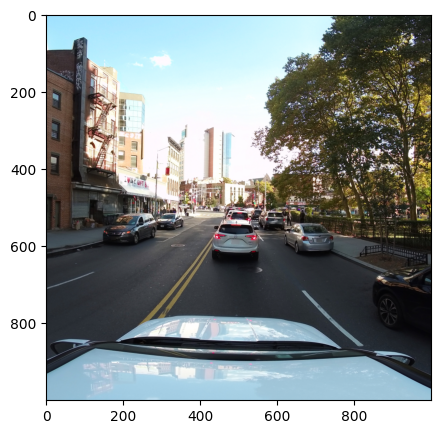

  Image 491: {
  "oneway": "no",
  "lanes:forward": "2",
  "lanes:backward": "2",
  "turn:lanes:forward": null,
  "turn:lanes:backward": null,
  "name": null,
  "maxspeed:forward": null,
  "maxspeed:backward": null
}


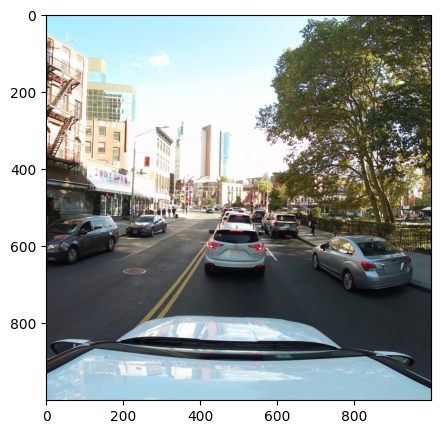

  Image 492: {
  "oneway": "no",
  "lanes:forward": "2",
  "lanes:backward": "2",
  "turn:lanes:forward": null,
  "turn:lanes:backward": null,
  "name": null,
  "maxspeed:forward": null,
  "maxspeed:backward": null
}


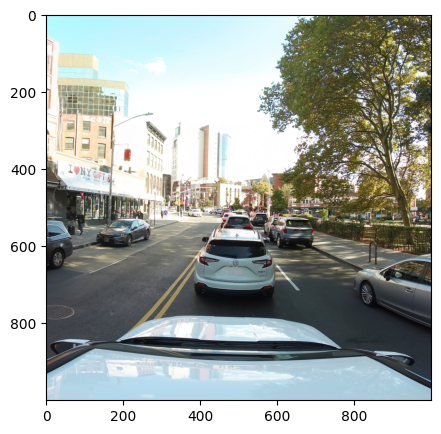

  Image 493: {
  "oneway": "no",
  "lanes:forward": "2",
  "lanes:backward": "2",
  "turn:lanes:forward": null,
  "turn:lanes:backward": null,
  "name": null,
  "maxspeed:forward": null,
  "maxspeed:backward": null
}


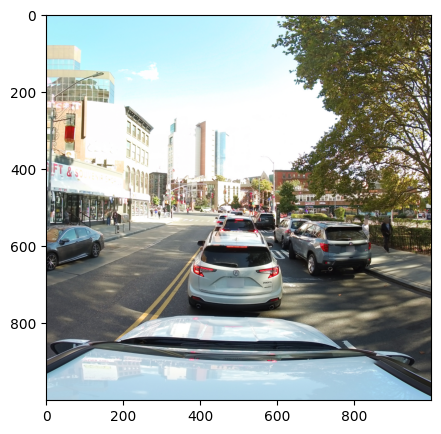

  Image 494: {
  "oneway": "no",
  "lanes:forward": "2",
  "lanes:backward": "1",
  "turn:lanes:forward": null,
  "turn:lanes:backward": null,
  "name": null,
  "maxspeed:forward": null,
  "maxspeed:backward": null
}


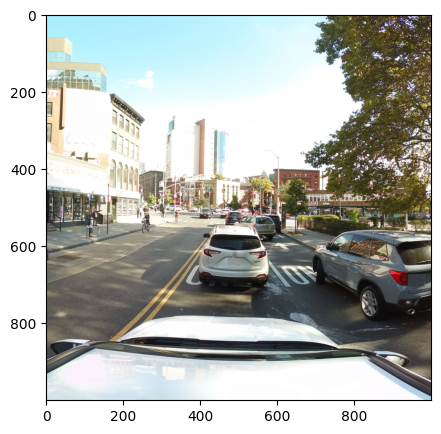

  Image 495: {
  "oneway": "no",
  "lanes:forward": "2",
  "lanes:backward": "1",
  "turn:lanes:forward": "through|right",
  "turn:lanes:backward": null,
  "name": null,
  "maxspeed:forward": null,
  "maxspeed:backward": null
}


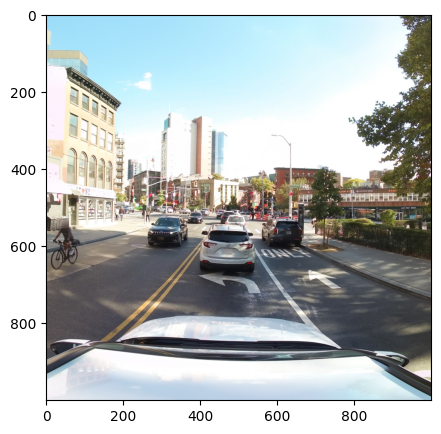

  Image 496: {
  "oneway": "no",
  "lanes:forward": "2",
  "lanes:backward": "1",
  "turn:lanes:forward": "left|through",
  "turn:lanes:backward": null,
  "name": null,
  "maxspeed:forward": null,
  "maxspeed:backward": null
}
  Final summary: 
  {
    "oneway": "no",
    "lanes:forward": "1",
    "lanes:backward": "2",
    "turn:lanes:forward": null,
    "turn:lanes:backward": "left|through",
    "name": null,
    "maxspeed:forward": null,
    "maxspeed:backward": null
  }


In [5]:
results = analyze_road_sequence(
    ways_df, 
    photos_df,
    osm_id_example, 
    load_and_resize_image, 
    get_front_view,
    verbose=True
)

In [6]:
response = results[osm_id_example][0][34523248][-1]['response']
response = response.replace("null", "None").replace("\n", "").replace(" ", "")

response = eval(response)

response['osmid'] = osm_id_example
for k, v in response.items():
    response[k] = [v]

In [7]:
response_df = pd.DataFrame.from_dict(response)
response_df

,oneway,lanes:forward,lanes:backward,turn:lanes:forward,turn:lanes:backward,name,maxspeed:forward,maxspeed:backward,osmid
0,no,1,2,None,left|through,None,None,None,1329887723


In [8]:
gt_df = load_metadata('../metadata/ground_truth.csv')
gt_df_example = gt_df[gt_df['osmid']==osm_id_example]
gt_df_example

,osmid,oneway,name,lanes:forward,turn:lanes:forward,lanes:backward,turn:lanes,maxspeed:forward,maxspeed,turn:lanes:backward,lanes
21,1329887723,no,Worth Street,NaN,NaN,NaN,NaN,NaN,20 mph,NaN,4.0
